# Survival for full cohort 

**The goal of this notebook is to median overall survival and hazard ratio for the full cohort of patients with advanced or metastatic urothelial cancer receiveing first-line monotherapy checkpoint inhibitor (eg., pembrolizumab or atezolizumab) vs. chemotherapy.** 

In [1]:
import numpy as np
import pandas as pd

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

## Merge treatment information with death date

In [3]:
cohort = pd.read_csv('full_cohort.csv')

In [4]:
cohort.sample(3)

,PatientID,LineName,StartDate
3530,F44607B65585B,chemo,2021-07-21
3036,F6AA076092830,chemo,2022-05-14
5244,FD2CE2EC2D7B6,chemo,2015-07-20


In [5]:
mortality = pd.read_csv('../data/Enhanced_Mortality_V2.csv')

In [6]:
mortality.sample(3)

,PatientID,DateOfDeath
1318,FFAD3E04CA0D3,2021-08
7465,F92B5B1B24E9E,2015-01
3971,FEF655322AE27,2021-11


In [7]:
row_ID(cohort)

(6775, 6775)

In [8]:
row_ID(mortality)

(9040, 9040)

In [9]:
trial_df = pd.merge(cohort, mortality, on = 'PatientID', how = 'left')

In [10]:
trial_df.sample(3)

,PatientID,LineName,StartDate,DateOfDeath
2437,FBE4C81E3EFA8,chemo,2014-10-16,2015-08
596,FC7F38EF68005,Pembrolizumab,2019-08-13,2021-11
3458,F52F33AC18CF1,chemo,2016-08-17,2017-06


In [11]:
row_ID(trial_df)

(6775, 6775)

In [12]:
# Patients with missing date of death
trial_df[trial_df.DateOfDeath.isna() == True].shape[0]

2079

In [13]:
# Patients with missing start date of treatment 
trial_df[trial_df.StartDate.isna() == True].shape[0]

0

In [14]:
trial_df[trial_df['StartDate'].str.len() < 10]  # Full date would be 10 characters (YYYY-MM-DD)

,PatientID,LineName,StartDate,DateOfDeath


In [15]:
trial_df[trial_df['DateOfDeath'].str.len() == 10].shape[0]

0

In [16]:
trial_df[trial_df['DateOfDeath'].str.len() == 7].shape[0] # 7 characters (YYYY-MM)

4690

In [17]:
trial_df[trial_df['DateOfDeath'].str.len() == 4].shape[0] # 4 characters (YYYY)

6

**StartDate is recorded at day-level precision, while DateOfDeath is recorded at month-level precision for patient de-identification. For DateOfDeath records with partial date information, Flatiron recommends the following imputation rules:**
- **When only month and year are available: Impute to the 15th day of the month**
- **When only year is available: Impute to July 1st (mid-year)**

In [18]:
trial_df['DateOfDeath'] = (
    np.where(trial_df['DateOfDeath'].str.len() == 4, trial_df['DateOfDeath'] + '-07-01', trial_df['DateOfDeath'])
)

In [19]:
trial_df['DateOfDeath'] = (
    np.where(trial_df['DateOfDeath'].str.len() == 7, trial_df['DateOfDeath'] + '-15', trial_df['DateOfDeath'])
)

In [20]:
trial_df['StartDate'] = pd.to_datetime(trial_df['StartDate'])
trial_df['DateOfDeath'] = pd.to_datetime(trial_df['DateOfDeath'])

In [21]:
trial_df.sample(3)

,PatientID,LineName,StartDate,DateOfDeath
6367,F0DD1A3E6203A,chemo,2023-10-20,NaT
850,F4B8F0DA06056,Atezolizumab,2017-12-08,2020-01-15
2521,F1EF00432497F,chemo,2021-07-08,NaT


## Patient censoring 

**For patients without a recorded date of death, we define their censor date as the last confirmed activity date in their EHR. This last confirmed activity date represents the most recent documented evidence of the patient being alive, as indicated by any of the following events:**
- **A clinical visit (recorded in the Visit table's VisitDate field)**
- **Oral medication activity (documented in Enhanced_AdvUrothelial_Orals table's StartDate or EndDate fields)**
- **Biomarker testing (logged in Enhanced_AdvUrothelialBiomarkers table's SpecimenCollectedDate field)**
- **Disease progression documentation (noted in Enhanced_AdvUrothelial_Progression table's LastClinicNoteDate or ProgressionDate fields)**

In [22]:
visit = pd.read_csv('../data/Visit.csv')
orals = pd.read_csv('../data/Enhanced_AdvUrothelial_Orals.csv')
biomarkers = pd.read_csv('../data/Enhanced_AdvUrothelialBiomarkers.csv')
progression = pd.read_csv ('../data/Enhanced_AdvUrothelial_Progression.csv')

### Visit

In [23]:
visit.sample(3)

,PatientID,PracticeID,VisitDate,VisitType,IsVitalsVisit,IsTreatmentVisit,IsLabVisit
320679,FF2E2392096C9,SC3260C6286CA,2017-04-21,Vitals,True,False,True
89986,FD782A18AC391,S0015D5ED587A,2017-11-12,Treatment,True,True,True
549455,F0E738A6C10AB,SCBCD489C3FC4,2014-04-09,Vitals,True,False,True


In [24]:
visit['VisitDate'] = pd.to_datetime(visit['VisitDate'])

In [25]:
visit_max = (
    visit
    .query("PatientID in @trial_df.PatientID")  
    .groupby('PatientID', observed = True)['VisitDate']  
    .max()
    .to_frame(name = 'last_visit_date')          
    .reset_index()
)

In [26]:
visit_max.sample(3)

,PatientID,last_visit_date
4186,F9F6C8BAF5895,2014-02-26
4996,FBD8990C3B644,2017-11-13
4985,FBCE962E6605B,2015-06-10


### Oral medicines

In [27]:
orals.sample(3)

,PatientID,DrugName,StartDate,EndDate,DateGranularity
40,FAE44999921D8,Clinical Study Drug,2021-08-26,2021-11-18,Day
98,F065A57FC3431,erdafitinib,2023-05-15,2023-06-25,Day
267,F2A45117086BA,erdafitinib,2021-07-15,2022-05-20,Day


In [28]:
orals['StartDate'] = pd.to_datetime(orals['StartDate'])
orals['EndDate'] = pd.to_datetime(orals['EndDate'])

In [29]:
orals_max = (
    orals
    .query("PatientID in @trial_df.PatientID")
    .assign(max_date = orals[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID', observed = True)['max_date'].max()
    .to_frame(name = 'last_oral_date')
    .reset_index()
)

In [30]:
orals_max.sample(3)

,PatientID,last_oral_date
121,FDF116F6D5862,2023-01-31
40,F54CA14F1A83E,2020-12-31
34,F494934D917A0,2022-03-02


### Biomarkers 

In [31]:
biomarkers.sample(1)

,PatientID,BiomarkerName,CellType,SpecimenCollectedDate,SpecimenReceivedDate,ResultDate,BiomarkerStatus,Gene,BiomarkerDetail,ExpressionLevel,SampleType,TissueCollectionSite,TestType,LabName,Assay,IHCClone,StainingIntensity,PercentStaining,CombinedPositiveScore
420,F4831D3566DFC,FGFR,NaN,2022-01-25,2022-04-11,2022-05-05,Negative,NaN,NaN,NaN,Tissue,Primary site,NGS,Quest Diagnostics,NaN,NaN,NaN,NaN,NaN


In [32]:
biomarkers['SpecimenCollectedDate'] = pd.to_datetime(biomarkers['SpecimenCollectedDate'])

In [33]:
biomarkers_max = (
    biomarkers
    .query("PatientID in @trial_df.PatientID")
    .groupby('PatientID', observed = True)['SpecimenCollectedDate'].max()
    .to_frame(name = 'biomarkers_max')
    .reset_index()
)

In [34]:
biomarkers_max.sample(3)

,PatientID,biomarkers_max
446,F293B8C4EB6D5,2013-03-15
47,F04BE9171C886,2021-08-20
2309,FD80D66A42A20,2017-10-05


### Progression

In [35]:
progression.sample(3)

,PatientID,ProgressionDate,ProgressionDateGranularity,IsRadiographicEvidence,IsPathologicEvidence,IsClinicalAssessmentOnly,IsMixedResponse,IsPseudoprogressionMentioned,LastClinicNoteDate
806,F0C38FF2A581D,2014-11-17,Day,Yes,No,No,No,No,2015-02-27
4264,F447EC405FA26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-12
4128,F41CEF9D16CBE,2021-12-22,Day,Yes,No,No,No,No,2022-02-08


In [36]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])
progression['LastClinicNoteDate'] = pd.to_datetime(progression['LastClinicNoteDate'])

In [37]:
progression_max = (
    progression
    .query("PatientID in @trial_df.PatientID")
    .assign(max_date = progression[['ProgressionDate', 'LastClinicNoteDate']].max(axis = 1))
    .groupby('PatientID', observed = True)['max_date'].max()
    .to_frame(name = 'progression_max')
    .reset_index()
)

In [38]:
progression_max.sample(3)

,PatientID,progression_max
3017,F73A0995B8569,2019-07-31
2900,F6EE49B21FDE4,2012-10-18
5350,FCB02233E8D51,2017-10-12


### Merging last EHR date

In [39]:
last_activity = pd.merge(visit_max, orals_max, on = 'PatientID', how = 'outer')
last_activity = pd.merge(last_activity, biomarkers_max, on = 'PatientID', how = 'outer')
last_activity = pd.merge(last_activity, progression_max, on = 'PatientID', how = 'outer')

In [40]:
row_ID(last_activity)

(6775, 6775)

In [41]:
# Find max of each row. 
last_activity = (
    last_activity
    .assign(last_activity = last_activity[['last_visit_date', 'last_oral_date', 'biomarkers_max', 'progression_max']].max(axis = 1))
    .filter(items = ['PatientID', 'last_activity'])
)

In [42]:
trial_df = pd.merge(trial_df, last_activity, on = 'PatientID')

In [43]:
row_ID(trial_df)

(6775, 6775)

In [44]:
trial_df.sample(3)

,PatientID,LineName,StartDate,DateOfDeath,last_activity
3428,F968B2AC69FD6,chemo,2015-02-25,NaT,2015-07-22
4852,F7927430B4B9F,chemo,2020-02-17,NaT,2023-10-23
1861,F261C4239AF79,Pembrolizumab,2021-05-18,2022-10-15,2021-08-03


## Creating event and duration columns

In [45]:
trial_df.dtypes

PatientID                object
LineName                 object
StartDate        datetime64[ns]
DateOfDeath      datetime64[ns]
last_activity    datetime64[ns]
dtype: object

In [46]:
trial_df['event'] = trial_df['DateOfDeath'].notna().astype(int)

In [47]:
trial_df['end_date'] = trial_df['DateOfDeath'].fillna(trial_df['last_activity'])

In [48]:
trial_df['duration'] = (trial_df['end_date'] - trial_df['StartDate']).dt.days

In [49]:
trial_df.query('duration < 0')

,PatientID,LineName,StartDate,DateOfDeath,last_activity,event,end_date,duration
348,FF42B7E5B8676,Atezolizumab,2022-05-16,2022-05-15,2022-05-23,1,2022-05-15,-1
421,FD1A0A26124FA,Pembrolizumab,2018-03-20,2018-03-15,2018-03-26,1,2018-03-15,-5
479,FC39EEFCB7C05,Atezolizumab,2017-04-19,2017-04-15,2017-04-19,1,2017-04-15,-4
693,F948144982293,Pembrolizumab,2018-10-26,2018-10-15,2018-10-26,1,2018-10-15,-11
1070,FEEA076876F9A,Atezolizumab,2017-11-20,2017-11-15,2017-11-20,1,2017-11-15,-5
1442,F7B261828E21A,Atezolizumab,2016-08-22,2016-08-15,2016-08-22,1,2016-08-15,-7
1706,F2A70849BAE11,Atezolizumab,2016-07-25,2016-07-15,2016-07-25,1,2016-07-15,-10
1957,F077F7E307F5E,Atezolizumab,2022-06-22,2022-06-15,2022-06-22,1,2022-06-15,-7
2216,FA90CA0B34A4B,chemo,2022-09-21,2022-09-15,2022-09-22,1,2022-09-15,-6
2687,F93004DA5D3B1,chemo,2019-10-16,2019-10-15,2019-10-16,1,2019-10-15,-1


In [50]:
trial_df = trial_df.query('duration >= 0')

In [51]:
trial_df.query('LineName == "chemo"').shape[0]

4601

In [52]:
trial_df.query('LineName == "Pembrolizumab"').shape[0]

1484

In [53]:
trial_df.query('LineName == "Atezolizumab"').shape[0]

675

## Calculating survival metrics 

### All checkpoint vs. chemotherapy 

In [54]:
kmf_checkpoint = KaplanMeierFitter()
kmf_chemo = KaplanMeierFitter()

kmf_checkpoint.fit(
    trial_df.query('LineName != "chemo"').duration/30,
    trial_df.query('LineName != "chemo"').event)

kmf_chemo.fit(
    trial_df.query('LineName == "chemo"').duration/30,
    trial_df.query('LineName == "chemo"').event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4601 total observations, 1434 right-censored observations>

<Axes: title={'center': '1L Checkpoint vs Chemotherapy'}, xlabel='Time (months)', ylabel='Survival probability'>

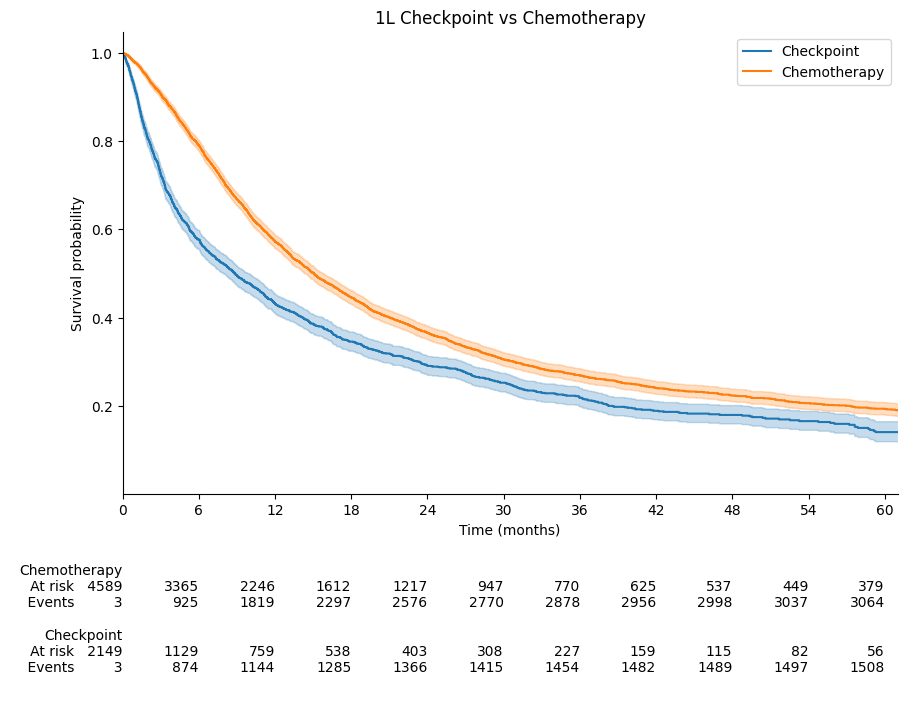

In [55]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both curves
kmf_checkpoint.plot(label = 'Checkpoint', ci_show = True)
kmf_chemo.plot(label = 'Chemotherapy', ci_show = True)

# Customize the plot
plt.title('1L Checkpoint vs Chemotherapy')

plt.xlabel('Time (months)') 
plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.ylabel('Survival probability')

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_chemo, kmf_checkpoint, rows_to_show = ['At risk', 'Events'], labels = ['Chemotherapy', 'Checkpoint'])

In [56]:
median_checkpoint = kmf_checkpoint.median_survival_time_
median_chemo = kmf_chemo.median_survival_time_

print(f"Median survival time for checkpoint therapy: {median_checkpoint:.1f} months")
print(f"Median survival time for chemotherapy: {median_chemo:.1f} months")

Median survival time for checkpoint therapy: 8.9 months
Median survival time for chemotherapy: 15.1 months


In [57]:
cox_df = trial_df.copy()
cox_df['treatment'] = (cox_df['LineName'] != 'chemo').astype(int)
cox_df['duration_months'] = cox_df['duration'] / 30

cox_check_chemo = CoxPHFitter()
cox_check_chemo.fit(cox_df,
                    duration_col = 'duration_months',
                    event_col = 'event', 
                    formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 6760 total observations, 2079 right-censored observations>

In [58]:
print(f"Hazard ratio: {cox_check_chemo.hazard_ratios_['treatment']:.2f} ({cox_check_chemo.summary.loc['treatment']['exp(coef) lower 95%']:.2f}, {cox_check_chemo.summary.loc['treatment']['exp(coef) upper 95%']:.2f})")

Hazard ratio: 1.42 (1.33, 1.51)


### Pembrolizumab vs. chemotherapy 

In [59]:
kmf_pembro = KaplanMeierFitter()
kmf_chemo = KaplanMeierFitter()

kmf_pembro.fit(
    trial_df.query('LineName == "Pembrolizumab"').duration/30,
    trial_df.query('LineName == "Pembrolizumab"').event)

kmf_chemo.fit(
    trial_df.query('LineName == "chemo"').duration/30,
    trial_df.query('LineName == "chemo"').event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4601 total observations, 1434 right-censored observations>

<Axes: title={'center': '1L Pembrolizumab vs Chemotherapy'}, xlabel='Time (months)', ylabel='Survival probability'>

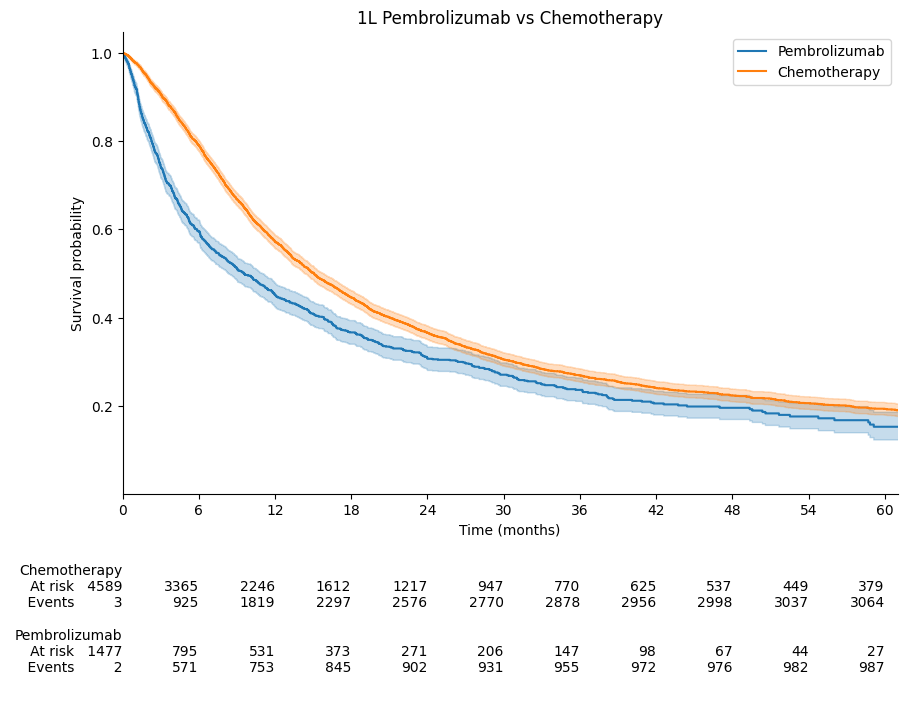

In [60]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both curves
kmf_pembro.plot(label = 'Pembrolizumab', ci_show = True)
kmf_chemo.plot(label = 'Chemotherapy', ci_show = True)

# Customize the plot
plt.title('1L Pembrolizumab vs Chemotherapy')

plt.xlabel('Time (months)') 
plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.ylabel('Survival probability')

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_chemo, kmf_pembro, rows_to_show = ['At risk', 'Events'], labels = ['Chemotherapy', 'Pembrolizumab'])

In [61]:
median_pembro = kmf_pembro.median_survival_time_
median_chemo = kmf_chemo.median_survival_time_

print(f"Median survival time for real-world pembrolizumab: {median_pembro:.1f} months")
print(f"Median survival time for real-world chemotherapy: {median_chemo:.1f} months")
print()
print("Median survival time for KEYNOTE-361 pembrolizumab: 15.6 (12.1-17.9) months")
print("Median survival time for KEYNOTE-361 chemotherapy: 14.3 (12.3-16.7) months")

Median survival time for real-world pembrolizumab: 9.6 months
Median survival time for real-world chemotherapy: 15.1 months

Median survival time for KEYNOTE-361 pembrolizumab: 15.6 (12.1-17.9) months
Median survival time for KEYNOTE-361 chemotherapy: 14.3 (12.3-16.7) months


In [62]:
cox_pembro_df = trial_df.copy()
cox_pembro_df = cox_pembro_df.query('LineName != "Atezolizumab"')
cox_pembro_df['treatment'] = (cox_pembro_df['LineName'] == 'Pembrolizumab').astype(int)
cox_pembro_df['duration_months'] = cox_pembro_df['duration'] / 30

cox_pembro = CoxPHFitter()
cox_pembro.fit(cox_pembro_df,
               duration_col = 'duration_months',
               event_col = 'event', 
               formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 6085 total observations, 1928 right-censored observations>

In [63]:
print(f"Hazard ratio real-world: {cox_pembro.hazard_ratios_['treatment']:.2f} ({cox_pembro.summary.loc['treatment']['exp(coef) lower 95%']:.2f}, {cox_pembro.summary.loc['treatment']['exp(coef) upper 95%']:.2f})")
print("Hazard ratio KEYNOTE-361: 0.92 (0.77-1.11)")

Hazard ratio real-world: 1.35 (1.26, 1.45)
Hazard ratio KEYNOTE-361: 0.92 (0.77-1.11)


### Atezolizumab vs. chemotherapy 

In [64]:
kmf_atezo = KaplanMeierFitter()
kmf_chemo = KaplanMeierFitter()

kmf_atezo.fit(
    trial_df.query('LineName == "Atezolizumab"').duration/30,
    trial_df.query('LineName == "Atezolizumab"').event)

kmf_chemo.fit(
    trial_df.query('LineName == "chemo"').duration/30,
    trial_df.query('LineName == "chemo"').event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4601 total observations, 1434 right-censored observations>

<Axes: title={'center': '1L Atezolizumab vs Chemotherapy'}, xlabel='Time (months)', ylabel='Survival probability'>

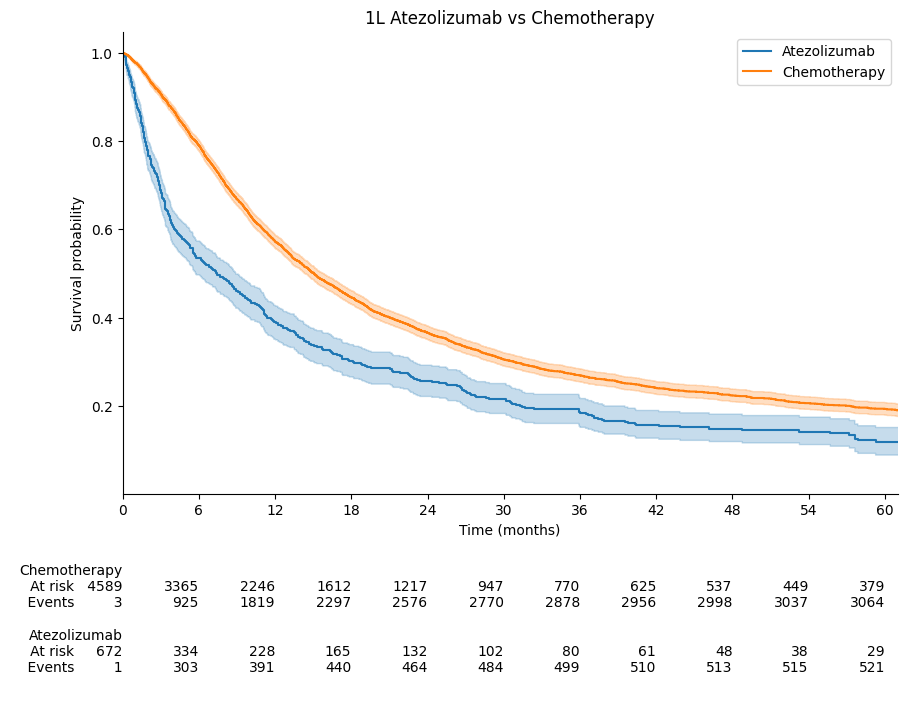

In [65]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both curves
kmf_atezo.plot(label = 'Atezolizumab', ci_show = True)
kmf_chemo.plot(label = 'Chemotherapy', ci_show = True)

# Customize the plot
plt.title('1L Atezolizumab vs Chemotherapy')

plt.xlabel('Time (months)') 
plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.ylabel('Survival probability')

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_chemo, kmf_atezo, rows_to_show = ['At risk', 'Events'], labels = ['Chemotherapy', 'Atezolizumab'])

In [66]:
median_atezo = kmf_atezo.median_survival_time_
median_chemo = kmf_chemo.median_survival_time_

print(f"Median survival time for real-world atezolizumab: {median_atezo:.1f} months")
print(f"Median survival time for real-world chemotherapy: {median_chemo:.1f} months")

Median survival time for real-world atezolizumab: 7.4 months
Median survival time for real-world chemotherapy: 15.1 months


In [67]:
cox_atezo_df = trial_df.copy()
cox_atezo_df = cox_atezo_df.query('LineName != "Pembrolizumab"')
cox_atezo_df['treatment'] = (cox_atezo_df['LineName'] == 'Atezolizumab').astype(int)
cox_atezo_df['duration_months'] = cox_atezo_df['duration'] / 30

cox_atezo = CoxPHFitter()
cox_atezo.fit(cox_atezo_df,
               duration_col = 'duration_months',
               event_col = 'event', 
               formula = 'treatment')

<lifelines.CoxPHFitter: fitted with 5276 total observations, 1585 right-censored observations>

In [68]:
print(f"Hazard ratio real-world: {cox_atezo.hazard_ratios_['treatment']:.2f} ({cox_atezo.summary.loc['treatment']['exp(coef) lower 95%']:.2f}, {cox_atezo.summary.loc['treatment']['exp(coef) upper 95%']:.2f})")

Hazard ratio real-world: 1.59 (1.45, 1.75)
